In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display, IFrame

# Pandas Tutor setup
%reload_ext pandas_tutor
%set_pandas_tutor_options {"maxDisplayCols": 8, "nohover": True, "projectorMode": True}

set_matplotlib_formats("svg")
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

def show_paradox_slides():
    src = 'https://docs.google.com/presentation/d/e/2PACX-1vSbFSaxaYZ0NcgrgqZLvjhkjX-5MQzAITWAsEFZHnix3j1c0qN8Vd1rogTAQP7F7Nf5r-JWExnGey7h/embed?start=false'
    width = 960
    height = 569
    display(IFrame(src, width, height))

# Lecture 3 – Aggregating, Simpson's paradox

## DSC 80, Fall 2023

### Agenda

- Data granularity.
- Grouping using `.groupby()` and `.resample()`.
- Pivot tables using `.pivot_table()`.
- Conditional probabilities
- Simpson's paradox

## 📣 Announcements 📣

- Good job turning in Lab 1!
- Lab 2 out, due Monday.
- Project 1 checkpoint due tomorrow.
    - Project 1 due next Wed.

## Data granularity

### Granularity

- **Granularity** refers to what each observation in a dataset represents.
    - Fine: small details.
    - Coarse: bigger picture.
- Most commonly, rows in a DataFrame correspond to observations, and columns correspond to attributes. Data formatted in this way is called [tidy data](https://r4ds.had.co.nz/tidy-data.html).

### Example: Baby Names

What is a single observation in the baby names data?

In [2]:
baby = pd.read_csv('data/baby.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,20456,2022
1,Noah,M,18621,2022
2,Olivia,F,16573,2022
3,Oliver,M,15076,2022
...,...,...,...,...
2085154,Worthy,M,5,1880
2085155,Wright,M,5,1880
2085156,York,M,5,1880
2085157,Zachariah,M,5,1880


### Example: CO2 readings

What is a single observation in this dataset of CO2 readings?

In [3]:
# Don't about this code, we'll cover it when we talk about data cleaning
co2 = pd.read_csv('data/co2_mm_mlo.txt', 
                  header=None, skiprows=72, sep='\s+',
                  names=['Yr', 'Mo', 'DecDate', 'Avg', 'co2', 'Trend', 'days'],
                  usecols=['Yr', 'Mo', 'DecDate', 'co2'])
co2

,Yr,Mo,DecDate,co2
0,1958,3,1958.21,315.71
1,1958,4,1958.29,317.45
2,1958,5,1958.38,317.50
3,1958,6,1958.46,317.10
...,...,...,...,...
734,2019,5,2019.38,414.66
735,2019,6,2019.46,413.92
736,2019,7,2019.54,411.77
737,2019,8,2019.62,409.95


### Example: CO2 readings by month

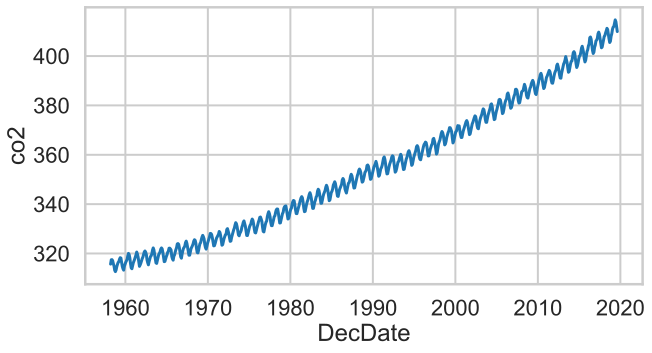

In [4]:
# Don't worry about understanding this code for now
sns.lineplot(data=co2, x='DecDate', y='co2');

### Collecting data

- If you can control how your dataset is created, you should opt for **finer granularity**, i.e. for more detail.
- You can easily remove detail, but it's difficult to add detail if it is not already present in the dataset.
- Tradeoff: obtaining fine-grained data can take more time/money.

### Manipulating granularity

- We'll now explore how to change the level of granularity present in our dataset.
    - While it may seem like we are "losing information," removing detail can help us understand bigger-picture trends in our data.

### Example: Penguins

<center><img src="imgs/lter_penguins.png" width=60%>
<i><a href="https://github.com/allisonhorst/palmerpenguins/blob/main/README.md">Artwork by @allison_horst</a></i>

</center>

The dataset we'll work with for the rest of the lecture involves various measurements taken of three species of penguins in Antarctica.

In [5]:
import seaborn as sns
penguins = sns.load_dataset('penguins').dropna()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


In [6]:
# What is the distribution of different 'species' in this dataset?
penguins['species'].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [7]:
# Overall, what is the distribution of different islands?
penguins['island'].value_counts()

Biscoe       163
Dream        123
Torgersen     47
Name: island, dtype: int64

### Video: Palmer Penguins

In [8]:
IFrame('https://www.youtube-nocookie.com/embed/CCrNAHXUstU?si=-DntSyUNp5Kwitjm&amp;start=11',
       width=560, height=315)

### Aggregating: Basics

We know how to find the mean body mass for all the penguins:

In [9]:
penguins['body_mass_g'].mean()

4207.057057057057

### 💡 Pro-Tip: Using f-strings

[Python f-strings](https://docs.python.org/3/tutorial/inputoutput.html#formatted-string-literals) give an easy way to print variables nicely:

In [10]:
mean_body_mass = penguins['body_mass_g'].mean()
print(f'Mean penguin mass: {mean_body_mass:.2f} grams')

Mean penguin mass: 4207.06 grams


### Aggregating: Basics

But what about the mean for each type of penguin?

In [11]:
penguins['body_mass_g'].mean()

4207.057057057057

### Naive approach: looping through unique values

In [12]:
species_map = pd.Series([], dtype=float)

for species in penguins['species'].unique():
    species_only = penguins.loc[penguins['species'] == species]
    species_map.loc[species] = species_only['body_mass_g'].mean()
    
species_map

Adelie       3706.16
Chinstrap    3733.09
Gentoo       5092.44
dtype: float64

- For each unique `'species'`, we make a pass through the entire dataset.
    - The asymptotic runtime of this procedure is $\Theta(ns)$, where $n$ is the number of rows and $s$ is the number of unique species.

- While there are other loop-based solutions that only involve a single pass over the DataFrame, we'd like to avoid Python loops entirely, as they're slow.

## Grouping

In [13]:
# Before:
penguins['body_mass_g'].mean()

# After:
penguins.groupby('species')['body_mass_g'].mean()

species
Adelie       3706.16
Chinstrap    3733.09
Gentoo       5092.44
Name: body_mass_g, dtype: float64

Somehow, the `groupby` method computes what we're looking for in just one line. How?

In [14]:
%%pt

penguins.groupby('species')['body_mass_g'].mean()

### "Split-apply-combine" paradigm

The `groupby` method involves three steps: **split**, **apply**, and **combine**. This is the same terminology that the [`pandas` documentation](https://pandas.pydata.org/docs/user_guide/groupby.html) uses.

<center><img src="imgs/image_0.png" width=40%></center>

- **Split** breaks up and "groups" the rows of a DataFrame according to the specified **key**. There is one "group" for every unique value of the key.

- **Apply** uses a function (e.g. aggregation, transformation, filtration) within the individual groups.

- **Combine** stitches the results of these operations into an output DataFrame.

- The split-apply-combine pattern can be **parallelized** to work on multiple computers or threads, by sending computations for each group to different processors.

### More examples

Before we dive into the internals, let's look at a few more examples.

In [15]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [16]:
penguins.shape

(333, 7)

Which `'species'` has the highest median `'bill_length_mm'`?

In [17]:
(penguins
 .groupby('species')
 .median()
 ['bill_length_mm']
 .idxmax()
)

'Chinstrap'

What proportion of penguins of each `'species'` live on `'Dream'` island?

In [18]:
(penguins
 .assign(on_dream = penguins['island'] == 'Dream')
 .groupby('species')
 .mean()['on_dream']
)

species
Adelie       0.38
Chinstrap    1.00
Gentoo       0.00
Name: on_dream, dtype: float64

## `DataFrameGroupBy` objects and aggregation

### `DataFrameGroupBy` objects

We've just evaluated a few expressions of the following form.

In [19]:
penguins.groupby('species').mean()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.82,18.35,190.10,3706.16
Chinstrap,48.83,18.42,195.82,3733.09
Gentoo,47.57,15.00,217.24,5092.44


There are two method calls in the expression above: `.groupby('species')` and `.mean()`. What happens if we remove the latter?

In [20]:
penguins.groupby('species')

### Peeking under the hood

If `df` is a DataFrame, then `df.groupby(key)` returns a `DataFrameGroupBy` object.

This object represents the "split" in "split-apply-combine".

In [21]:
# Simplified table for demostration:
penguins_small = penguins.iloc[[0, 1, 150, 151, 251, 300, 301], [0, 5, 6]]

# Creates one group for each unique value in the species column.
penguin_groups = penguins_small.groupby('species')
penguin_groups

In [22]:
%%pt
penguin_groups

`DataFrameGroupBy` objects have a `groups` attribute, which is a dictionary in which the keys are group names and the values are lists of row labels.

In [23]:
penguin_groups.groups

{'Adelie': [0, 1], 'Chinstrap': [156, 157], 'Gentoo': [258, 308, 309]}

`DataFrameGroupBy` objects also have a `get_group(key)` method, which returns a DataFrame with only the values for the given key.

In [24]:
penguin_groups.get_group('Chinstrap')

,species,body_mass_g,sex
156,Chinstrap,3725.0,Male
157,Chinstrap,3950.0,Female


In [25]:
# Same as the above!
penguins_small.query('species == "Chinstrap"')

,species,body_mass_g,sex
156,Chinstrap,3725.0,Male
157,Chinstrap,3950.0,Female


We usually don't use these attributes and methods, but they're useful in understanding how `groupby` works under the hood.

### Aggregation

- Once we create a `DataFrameGroupBy` object, we need to **apply** some function to each group, and **combine** the results.

- The most common operation we apply to each group is an **aggregation**.
    - Aggregation refers to the process of reducing many values to one.

- To perform an aggregation, use an aggregation method on the `DataFrameGroupBy` object, e.g. `.mean()`, `.max()`, or `.median()`.

Let's look at some examples.

In [26]:
penguins_small

,species,body_mass_g,sex
0,Adelie,3750.0,Male
1,Adelie,3800.0,Female
156,Chinstrap,3725.0,Male
157,Chinstrap,3950.0,Female
258,Gentoo,4350.0,Female
308,Gentoo,4875.0,Female
309,Gentoo,5550.0,Male


In [27]:
penguins_small.groupby('species').mean()

,body_mass_g
species,
Adelie,3775.0
Chinstrap,3837.5
Gentoo,4925.0


In [28]:
penguins_small.groupby('species').sum()

,body_mass_g
species,
Adelie,7550.0
Chinstrap,7675.0
Gentoo,14775.0


In [29]:
penguins_small.groupby('species').last()

,body_mass_g,sex
species,,
Adelie,3800.0,Female
Chinstrap,3950.0,Female
Gentoo,5550.0,Male


In [30]:
penguins_small.groupby('species').max()

,body_mass_g,sex
species,,
Adelie,3800.0,Male
Chinstrap,3950.0,Male
Gentoo,5550.0,Male


### Column independence

Within each group, the aggregation method is applied to **each column independently**.

In [31]:
penguins_small.groupby('species').max()

,body_mass_g,sex
species,,
Adelie,3800.0,Male
Chinstrap,3950.0,Male
Gentoo,5550.0,Male


It **is not** telling us that there is a male `'Adelie'` penguin with a `'body_mass_g'` of `3800.0`!

In [32]:
# This penguin is Female!
penguins_small.loc[(penguins['species'] == 'Adelie') & (penguins['body_mass_g'] == 3800.0)]

,species,body_mass_g,sex
1,Adelie,3800.0,Female


### Discussion Question

Find the species and weights of the heaviest `Male` and `Female` penguins.

In [33]:
# Fill in this cell

### Column selection and performance implications

- By default, the aggregator will be applied to **all** columns that it can be applied to.
    - `max` and `min` are defined on strings, while `median` and `mean` are not.

- If we only care about one column, we can select that column before aggregating **to save time**.
    - `DataFrameGroupBy` objects support `[]` notation, just like `DataFrame`s.

In [34]:
# Back to the big penguins dataset
penguins.groupby('species').mean()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.82,18.35,190.10,3706.16
Chinstrap,48.83,18.42,195.82,3733.09
Gentoo,47.57,15.00,217.24,5092.44


In [35]:
# Works, but involves wasted effort since the other columns had to be aggregated for no reason.
penguins.groupby('species').mean()['bill_length_mm']

species
Adelie       38.82
Chinstrap    48.83
Gentoo       47.57
Name: bill_length_mm, dtype: float64

In [36]:
# This is a SeriesGroupBy object!
penguins.groupby('species')['bill_length_mm']

In [37]:
# Saves time!
penguins.groupby('species')['bill_length_mm'].mean()

species
Adelie       38.82
Chinstrap    48.83
Gentoo       47.57
Name: bill_length_mm, dtype: float64

To demonstrate that the former is slower than the latter, we can use `%%timeit`. For reference, we'll also include our earlier `for`-loop-based solution.

In [38]:
%%timeit
penguins.groupby('species').mean()['bill_length_mm']

359 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
%%timeit
penguins.groupby('species')['bill_length_mm'].mean()

137 µs ± 659 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
%%timeit
species_map = pd.Series([], dtype=float)

for species in penguins['species'].unique():
    species_only = penguins.loc[penguins['species'] == species]
    species_map.loc[species] = species_only['body_mass_g'].mean()
    
species_map

981 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Takeaways

- It's important to understand _what_ each piece of your code evaluates to – in the first two timed examples, the code is almost identical, but the performance is quite different.

                # Slower
                penguins.groupby('species').mean()['bill_length_mm']

                # Faster
                penguins.groupby('species')['bill_length_mm'].mean()

- The `groupby` method is much quicker than `for`-looping over the DataFrame in Python. It can often produce results using just a **single, fast pass** over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.

### Beyond default aggregation methods

- There are many built-in aggregation methods.
- What if you want to apply different aggregation methods to different columns?
- What if the aggregation method you want to use doesn't already exist in `pandas`?

### The `aggregate` method

- The `DataFrameGroupBy` object has a general `aggregate` method, which aggregates using one or more operations.
    - Remember, aggregation refers to the process of reducing many values to one.
- There are many ways of using `aggregate`; refer to [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html) for a comprehensive list.
- Example arguments:
    - A single function.
    - A list of functions.
    - A dictionary mapping column names to functions.
- Per [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html), `agg` is an alias for `aggregate`.

### Example

How many penguins are there of each `'species'`, and what is the mean `'body_mass_g'` of each species?

In [41]:
(penguins
 .groupby('species')
 ['body_mass_g']
 .aggregate(['count', 'mean'])
)

,count,mean
species,,
Adelie,146,3706.16
Chinstrap,68,3733.09
Gentoo,119,5092.44


Note what happens when we don't select a column before aggregating.

In [42]:
(penguins
 .groupby('species')
 .aggregate(['count', 'mean'])
)

bill_length_mm        bill_depth_mm        flipper_length_mm  \
                   count   mean         count   mean             count   
species                                                                  
Adelie               146  38.82           146  18.35               146   
Chinstrap             68  48.83            68  18.42                68   
Gentoo               119  47.57           119  15.00               119   

                  body_mass_g           
             mean       count     mean  
species                                 
Adelie     190.10         146  3706.16  
Chinstrap  195.82          68  3733.09  
Gentoo     217.24         119  5092.44

### Example

What is the maximum `'bill_length_mm'` of each species, and which `'island'`s is each `'species'` found on?

In [43]:
(penguins
 .groupby('species')
 .aggregate({'bill_length_mm': 'max', 'island': 'nunique'})
)

,bill_length_mm,island
species,,
Adelie,46.0,3
Chinstrap,58.0,1
Gentoo,59.6,1


### Example

What is the **interquartile range** of the `'body_mass_g'` of each `'species'`?

In [44]:
# The function for .agg takes in a pd.Series as its argument and returns a scalar 
def iqr(series):
    return np.percentile(series, 75) - np.percentile(series, 25)

(penguins
 .groupby('species')
 ['body_mass_g']
 .agg(iqr)
)

species
Adelie       637.5
Chinstrap    462.5
Gentoo       800.0
Name: body_mass_g, dtype: float64

## Other `DataFrameGroupBy` methods

### Split-apply-combine, revisited

When we introduced the split-apply-combine pattern, the "apply" step involved **aggregation** – our final DataFrame had one row for each group.

<center><img src="imgs/image_0.png" width=40%></center>

Instead of aggregating during the apply step, we could instead perform a:

- **Transformation**, in which we perform operations to every value within each group.

- **Filtration**, in which we keep only the groups that satisfy some condition.

### Transformations

- Suppose we want to convert the `'body_mass_g'` column to to z-scores (i.e. standard units):

$$z(x_i) = \frac{x_i - \text{mean of } x}{\text{SD of } x}$$

In [45]:
def z_score(x):
    return (x - x.mean()) / x.std(ddof=0)

In [46]:
z_score(penguins['body_mass_g'])

0     -0.57
1     -0.51
2     -1.19
4     -0.94
       ... 
340    0.80
341    1.92
342    1.23
343    1.48
Name: body_mass_g, Length: 333, dtype: float64

### Transformations within groups

- Now, what if we wanted the z-score within each group?

- To do so, we can use the `transform` method on a `DataFrameGroupBy` object. The `transform` method takes in a function, which itself takes in a Series and returns a new Series.

- A transformation produces a DataFrame or Series of the same size – it is **not** an aggregation!

In [47]:
z_mass = (penguins
          .groupby('species')
          ['body_mass_g']
          .transform(z_score))
z_mass

0      0.10
1      0.21
2     -1.00
4     -0.56
       ... 
340   -0.49
341    1.32
342    0.22
343    0.62
Name: body_mass_g, Length: 333, dtype: float64

In [48]:
penguins.assign(z_mass=z_mass)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,z_mass
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0.10
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0.21
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,-1.00
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,-0.56
...,...,...,...,...,...,...,...,...
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,-0.49
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1.32
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,0.22
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male,0.62


Note that below, penguin 340 has a larger `'body_mass_g'` than penguin 0, but a lower `'z_mass'`. 
- Penguin 0 has an above average `'body_mass_g'` among `'Adelie'` penguins.
- Penguin 340 has a below average `'body_mass_g'` among `'Gentoo'` penguins. Remember from earlier that the average `'body_mass_g'` of `'Gentoo'` penguins is much higher than for other species.

### Filtering Groups

- To keep only the groups that satisfy a particular condition, use the `filter` method on a `DataFrameGroupBy` object.

- The `filter` method takes in a function, which itself takes in a DataFrame/Series and return a single Boolean. The result is a new DataFrame/Series with only the groups for which the filter function returned `True`.

For example, suppose we want only the `'species'` whose average `'bill_length_mm'` is above 39.

In [49]:
(penguins
 .groupby('species')
 .filter(lambda df: df['bill_length_mm'].mean() > 39)
)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
152,Chinstrap,Dream,46.5,17.9,192.0,3500.0,Female
153,Chinstrap,Dream,50.0,19.5,196.0,3900.0,Male
154,Chinstrap,Dream,51.3,19.2,193.0,3650.0,Male
155,Chinstrap,Dream,45.4,18.7,188.0,3525.0,Female
...,...,...,...,...,...,...,...
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


No more `'Adelie'`s!

Or, as another example, suppose we only want `'species'` with at least 100 penguins:

In [50]:
penguins.groupby('species').filter(lambda df: df.shape[0] > 100)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
343,Gentoo,Biscoe,49.9,16.1,213.0,5400.0,Male


No more `'Chinstrap'`s!

### Grouping with multiple columns

When we group with multiple columns, one group is created for **every unique combination** of elements in the specified columns.

In [51]:
species_and_island = penguins.groupby(['species', 'island']).mean()
species_and_island

bill_length_mm  bill_depth_mm  flipper_length_mm  \
species   island                                                        
Adelie    Biscoe              38.98          18.37             188.80   
          Dream               38.52          18.24             189.93   
          Torgersen           39.04          18.45             191.53   
Chinstrap Dream               48.83          18.42             195.82   
Gentoo    Biscoe              47.57          15.00             217.24   

                     body_mass_g  
species   island                  
Adelie    Biscoe         3709.66  
          Dream          3701.36  
          Torgersen      3708.51  
Chinstrap Dream          3733.09  
Gentoo    Biscoe         5092.44

### Grouping and indexes

- The `groupby` method creates an index based on the specified columns.
- When grouping by multiple columns, the resulting DataFrame has a `MultiIndex`.
- Advice: When working with a `MultiIndex`, use `reset_index` or set `as_index=False` in `groupby`.

In [52]:
species_and_island

bill_length_mm  bill_depth_mm  flipper_length_mm  \
species   island                                                        
Adelie    Biscoe              38.98          18.37             188.80   
          Dream               38.52          18.24             189.93   
          Torgersen           39.04          18.45             191.53   
Chinstrap Dream               48.83          18.42             195.82   
Gentoo    Biscoe              47.57          15.00             217.24   

                     body_mass_g  
species   island                  
Adelie    Biscoe         3709.66  
          Dream          3701.36  
          Torgersen      3708.51  
Chinstrap Dream          3733.09  
Gentoo    Biscoe         5092.44

In [53]:
species_and_island['body_mass_g']

species    island   
Adelie     Biscoe       3709.66
           Dream        3701.36
           Torgersen    3708.51
Chinstrap  Dream        3733.09
Gentoo     Biscoe       5092.44
Name: body_mass_g, dtype: float64

In [54]:
species_and_island.loc['Adelie']

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
island,,,,
Biscoe,38.98,18.37,188.80,3709.66
Dream,38.52,18.24,189.93,3701.36
Torgersen,39.04,18.45,191.53,3708.51


In [55]:
species_and_island.loc[('Adelie', 'Torgersen')]

bill_length_mm         39.04
bill_depth_mm          18.45
flipper_length_mm     191.53
body_mass_g          3708.51
Name: (Adelie, Torgersen), dtype: float64

In [56]:
species_and_island.reset_index()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Biscoe,38.98,18.37,188.80,3709.66
1,Adelie,Dream,38.52,18.24,189.93,3701.36
2,Adelie,Torgersen,39.04,18.45,191.53,3708.51
3,Chinstrap,Dream,48.83,18.42,195.82,3733.09
4,Gentoo,Biscoe,47.57,15.00,217.24,5092.44


In [57]:
penguins.groupby(['species', 'island'], as_index=False).mean()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Biscoe,38.98,18.37,188.80,3709.66
1,Adelie,Dream,38.52,18.24,189.93,3701.36
2,Adelie,Torgersen,39.04,18.45,191.53,3708.51
3,Chinstrap,Dream,48.83,18.42,195.82,3733.09
4,Gentoo,Biscoe,47.57,15.00,217.24,5092.44


## Discussion: Checking your knowledge

Find the most popular male and female baby name for each year in the dataset. Exclude years where there were fewer than 1 million births recorded.

In [58]:
baby = pd.read_csv('data/baby.csv')
baby

,Name,Sex,Count,Year
0,Liam,M,20456,2022
1,Noah,M,18621,2022
2,Olivia,F,16573,2022
3,Oliver,M,15076,2022
...,...,...,...,...
2085154,Worthy,M,5,1880
2085155,Wright,M,5,1880
2085156,York,M,5,1880
2085157,Zachariah,M,5,1880


In [59]:
# Fill me in

## Pivot Tables: An extension of grouping

Pivot tables are a compact way to display tables for humans to read:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Sex</th>
      <th>F</th>
      <th>M</th>
    </tr>
    <tr>
      <th>Year</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2018</th>
      <td>1698373</td>
      <td>1813377</td>
    </tr>
    <tr>
      <th>2019</th>
      <td>1675139</td>
      <td>1790682</td>
    </tr>
    <tr>
      <th>2020</th>
      <td>1612393</td>
      <td>1721588</td>
    </tr>
    <tr>
      <th>2021</th>
      <td>1635800</td>
      <td>1743913</td>
    </tr>
    <tr>
      <th>2022</th>
      <td>1628730</td>
      <td>1733166</td>
    </tr>
  </tbody>
</table>

- Notice that each value in the table is a sum over the counts, split by year and sex.
- You can think of pivot tables as grouping using two columns, then "pivoting" one of the group keys into columns

### `pivot_table`

The `pivot_table` DataFrame method aggregates a DataFrame using two columns. To use it:

```py
df.pivot_table(index=index_col,
               columns=columns_col,
               values=values_col,
               aggfunc=func)
```
The resulting DataFrame will have:
- One row for every unique value in `index_col`.
- One column for every unique value in `columns_col`.
- Values determined by applying `func` on values in `values_col`.

In [60]:
last_5_years = baby.query('Year >= 2018')

In [61]:
last_5_years.pivot_table(
    index='Year',
    columns='Sex',
    values='Count',
    aggfunc='sum',
)

Sex,F,M
Year,,
2018,1698373,1813377
2019,1675139,1790682
2020,1612393,1721588
2021,1635800,1743913
2022,1628730,1733166


In [62]:
# Look at the similarity to the snippet above
(last_5_years
 .groupby(['Year', 'Sex'])
 ['Count']
 .sum()
 .unstack('Sex')
)

Sex,F,M
Year,,
2018,1698373,1813377
2019,1675139,1790682
2020,1612393,1721588
2021,1635800,1743913
2022,1628730,1733166


### Example:

Find the number of penguins per island and species.

In [63]:
penguins.pivot_table(
    index='species', 
    columns='island', 
    values='bill_length_mm', # Choice of column here doesn't actually matter
    aggfunc='count',
)

island,Biscoe,Dream,Torgersen
species,,,
Adelie,44.0,55.0,47.0
Chinstrap,NaN,68.0,NaN
Gentoo,119.0,NaN,NaN


Note that there is a `NaN` at the intersection of `'Biscoe'` and `'Chinstrap'`, because there were no Chinstrap penguins on Biscoe Island.

We can either use the `fillna` method afterwards or the `fill_value` argument to fill in `NaN`s.

In [64]:
penguins.pivot_table(
    index='species', 
    columns='island', 
    values='bill_length_mm', 
    aggfunc='count',
    fill_value=0,
)

island,Biscoe,Dream,Torgersen
species,,,
Adelie,44,55,47
Chinstrap,0,68,0
Gentoo,119,0,0


### Granularity, revisited

Take another look at the pivot table from the previous cell. Each row of the original `penguins` represented a single penguin, and each column represented features of the penguins.

What is the granularity of this table?

In [65]:
penguins.pivot_table(
    index='species', 
    columns='island', 
    values='bill_length_mm', 
    aggfunc='count',
    fill_value=0,
)

island,Biscoe,Dream,Torgersen
species,,,
Adelie,44,55,47
Chinstrap,0,68,0
Gentoo,119,0,0


### Reshaping

- `pivot_table` reshapes DataFrames from "long" to "wide".
- Other DataFrame reshaping methods:
    - `melt`: Un-pivots a DataFrame. Very useful in data cleaning.
    - `pivot`: Like `pivot_table`, but doesn't do aggregation.
    - `stack`: Pivots multi-level columns to multi-indices.
    - `unstack`: Pivots multi-indices to columns.
    - Google and the documentation are your friends!

## Distributions

### Joint distribution

When using `aggfunc='count'`, a pivot table describes the **joint distribution** of two categorical variables. This is also called a **contingency table**.

In [66]:
counts = penguins.pivot_table(
    index='species', 
    columns='sex', 
    values='body_mass_g', 
    aggfunc='count', 
    fill_value=0
)
counts

sex,Female,Male
species,,
Adelie,73,73
Chinstrap,34,34
Gentoo,58,61


We can normalize the DataFrame by dividing by the total number of penguins. The resulting numbers can be interpreted as **probabilities** that a randomly selected penguin from the dataset belongs to a given combination of species and sex.

In [67]:
joint = counts / counts.sum().sum()
joint

sex,Female,Male
species,,
Adelie,0.22,0.22
Chinstrap,0.10,0.10
Gentoo,0.17,0.18


### Marginal probabilities

If we sum over one of the axes, we can compute **marginal probabilities**, i.e. unconditional probabilities.

In [68]:
joint

sex,Female,Male
species,,
Adelie,0.22,0.22
Chinstrap,0.10,0.10
Gentoo,0.17,0.18


In [69]:
# Recall, joint.sum(axis=0) sums across the rows, which computes the sum of the **columns**.
joint.sum(axis=0)

sex
Female    0.5
Male      0.5
dtype: float64

In [70]:
joint.sum(axis=1)

species
Adelie       0.44
Chinstrap    0.20
Gentoo       0.36
dtype: float64

For instance, the second Series tells us that a randomly selected penguin has a 0.36 chance of being of species `'Gentoo'`.

### Conditional probabilities

Using `counts`, how might we compute conditional probabilities like $$P(\text{species } = \text{"Adelie"} \mid \text{sex } = \text{"Female"})?$$

In [71]:
counts

sex,Female,Male
species,,
Adelie,73,73
Chinstrap,34,34
Gentoo,58,61


$$\begin{align*}
P(\text{species} = c \mid \text{sex} = x) &= \frac{P(\text{species} = c \text{ and } \text{sex} = x)}{P(\text{sex = }x)} \\
&= \frac{\frac{\# \: (\text{species } = \: c \text{ and } \text{sex } = \: x)}{N}}{\frac{\# \: (\text{sex } = \: x)}{N}} \\
&= \frac{\# \: (\text{species} = c \text{ and } \text{sex} = x)}{\# \: (\text{sex} = x)}
\end{align*}$$

**Answer**: To find conditional probabilities of **species given sex**, divide by **column sums**. To find conditional probabilities of **sex given species**, divide by **row sums**.

### Conditional probabilities

To find conditional probabilities of **species given sex**, divide by **column sums**. To find conditional probabilities of **sex given species**, divide by **row sums**.

In [72]:
counts

sex,Female,Male
species,,
Adelie,73,73
Chinstrap,34,34
Gentoo,58,61


In [73]:
counts.sum(axis=0)

sex
Female    165
Male      168
dtype: int64

The conditional distribution of **species given sex** is below. Note that in this new DataFrame, the `'Female'` and `'Male'` columns each sum to 1.

In [74]:
counts / counts.sum(axis=0)

sex,Female,Male
species,,
Adelie,0.44,0.43
Chinstrap,0.21,0.20
Gentoo,0.35,0.36


For instance, the above DataFrame tells us that the probability that a randomly selected penguin is of species `'Adelie'` **given** that they are of sex `'Female'` is 0.442424.

**Exercise**: Try and find the conditional distribution of **sex given species**.

## Simpson's paradox

<center><img src="imgs/simpsons.png" width=50%></center>

### Example: Grades

- Two students, Lisa and Bart, just finished freshman year. They both took a different number of classes in Fall, Winter, and Spring.

- Each quarter, Lisa had a higher GPA than Bart.

- But Bart has a higher overall GPA.

- How is this possible? 🤔

Run this cell to create DataFrames that contain each students' grades.

In [75]:
lisa = pd.DataFrame([
        [20, 46],
        [18, 54],
        [5, 20],
    ],
    columns=['Units', 'Grade Points Earned'], 
    index=['Fall', 'Winter', 'Spring'],
)

bart = pd.DataFrame([
        [5, 10],
        [5, 13.5],
        [22, 81.4],
    ],
    columns=['Units', 'Grade Points Earned'], 
    index=['Fall', 'Winter', 'Spring'],
)

### Quarter-specific vs. overall GPAs

**Note:** The number of "grade points" earned for a course is

$$\text{number of units} \cdot \text{grade (out of 4)}$$

For instance, an A- in a 4 unit course earns $3.7 \cdot 4 = 14.8$ grade points.

In [76]:
lisa

,Units,Grade Points Earned
Fall,20,46
Winter,18,54
Spring,5,20


In [77]:
bart

,Units,Grade Points Earned
Fall,5,10.0
Winter,5,13.5
Spring,22,81.4


Lisa had a higher GPA in all three quarters:

In [78]:
quarterly_gpas = pd.DataFrame({
    "Lisa's Quarter GPA": lisa['Grade Points Earned'] / lisa['Units'],
    "Bart's Quarter GPA": bart['Grade Points Earned'] / bart['Units'],
})

quarterly_gpas

,Lisa's Quarter GPA,Bart's Quarter GPA
Fall,2.3,2.0
Winter,3.0,2.7
Spring,4.0,3.7


But Lisa's overall GPA was less than Bart's overall GPA:

In [79]:
tot = lisa.sum()
tot['Grade Points Earned'] / tot['Units']

2.7906976744186047

In [80]:
tot = bart.sum()
tot['Grade Points Earned'] / tot['Units']

3.278125

### What happened?

In [81]:
(quarterly_gpas
 .assign(Lisa_units=lisa['Units'],
         Bart_units=bart['Units']) 
 .iloc[:, [0, 2, 1, 3]]
)

,Lisa's Quarter GPA,Lisa_units,Bart's Quarter GPA,Bart_units
Fall,2.3,20,2.0,5
Winter,3.0,18,2.7,5
Spring,4.0,5,3.7,22


- When Lisa and Bart both performed poorly, Lisa took more units than Bart. **This brought down 📉 Lisa's overall average.**

- When Lisa and Bart both performed well, Bart took more units than Annie. **This brought up 📈 Bart's overall average.**

### Simpson's paradox

- Simpson's paradox occurs when **grouped data and ungrouped data show opposing trends**.
    - It is named after Edward H. Simpson, not Lisa or Bart Simpson.

- It is **purely arithmetic** – it is a consequence of weighted averages.

- It often happens because there is a hidden factor (i.e. a **confounder**) within the data that influences results.

- **Question:** What is the "correct" way to summarize your data? What if you had to act on these results?

### Example: How Berkeley was _almost_ sued for gender discrimination (1973)

What do you notice?

<center><img src='imgs/berkeley.png' width=70%></center>

In [82]:
show_paradox_slides()

### What happened?

- The overall acceptance rate for women (30%) was lower than it was for men (45%).

- However, most departments (A, B, D, F) had a higher acceptance rate for women.


- Department A had a 62% acceptance rate for men and an 82% acceptance rate for women!
    - 31% of men applied to Department A.
    - 6% of women applied to Department A.

- Department F had a 6% acceptance rate for men and a 7% acceptance rate for women!
    - 14% of men applied to Department F.
    - 19% of women applied to Department F.

- **Conclusion:** Women tended to apply to departments with a lower acceptance rate; the data don't support the hypothesis that there was major gender discrimination against women.

### Caution!

This doesn't mean that admissions are free from gender discrimination! 

From [Moss-Racusin et al., 2012, PNAS](https://www.pnas.org/doi/10.1073/pnas.1211286109) (cited 2600+ times):

> In a randomized double-blind study (n = 127), **science faculty** from research-intensive universities **rated the application materials of a student—who was randomly assigned either a male or female** name—for a laboratory manager position. Faculty **participants rated the male applicant as significantly more competent and hireable than the (identical) female applicant**. These participants also selected a higher starting salary and offered more career mentoring to the male applicant. The gender of the faculty participants did not affect responses, such that female and male faculty were equally likely to exhibit bias against the female student.

### But then...

From [Williams and Ceci, 2015, PNAS](https://www.pnas.org/doi/10.1073/pnas.1418878112):

> Here we report five hiring experiments in which faculty evaluated hypothetical female and male applicants, using systematically varied profiles disguising identical scholarship, for assistant professorships in biology, engineering, economics, and psychology. Contrary to prevailing assumptions, **men and women faculty members from all four fields preferred female applicants 2:1 over identically qualified males** with matching lifestyles (single, married, divorced), with the exception of male economists, who showed no gender preference.

### Do these conflict?

Not necessarily. One explanation, from William and Ceci:

> Instead, past studies have used ratings of students’ hirability for a range of posts that do not include tenure-track jobs, such as managing laboratories or performing math assignments for a company. However, hiring tenure-track faculty differs from hiring lower-level staff: it entails selecting among highly accomplished candidates, all of whom have completed Ph.D.s and amassed publications and strong letters of support. **Hiring bias may occur when applicants’ records are ambiguous, as was true in studies of hiring bias for lower-level staff posts, but such bias may not occur when records are clearly strong**, as is the case with tenure-track hiring.

### Do these conflict?

From Witteman, et al, 2019, in *The Lancet*:

> Thus, evidence of scientists favouring women comes exclusively from hypothetical scenarios, whereas evidence of scientists favouring men comes from hypothetical scenarios and real behaviour. This **might reflect academics' growing awareness of the social desirability of achieving gender balance, while real academic behaviour might not yet put such ideals into action**.

### Example: Restaurant reviews and phone types

* You are deciding whether to eat at Dirty Birds or The Loft.

* Suppose Yelp shows ratings aggregated by phone type (Android vs. iPhone).

|Phone Type|Stars for Dirty Birds|Stars for The Loft|
|---|---|---|
|Android|4.24|4.0|
|iPhone|2.99|2.79|
|**All**|**3.32**|**3.37**|


* **Question**: Should you choose Dirty Birds or The Loft? 


* **Answer**: The type of phone you use likely has nothing to do with your taste in food – pick the restaurant that is rated higher overall.

* Remember, Simpson's paradox is merely a property of weighted averages!

### Takeaways

Be skeptical of...

- Aggregate statistics.
- People misusing statistics to "prove" that discrimination doesn't exist.
- Drawing conclusions from individual publications ($p$-hacking, publication bias, narrow focus, etc.).
- Everything!

**We need to apply domain knowledge and human judgement calls to decide what to do when Simpson's paradox is present.**

### Really?

To handle Simpson's paradox with rigor, we need some ideas from causal inference which we don't have time to cover in DSC 80. This video has a good example of how to approach Simpson's paradox, using a minimal amount of causal inference, if you're curious (not required for DSC 80).

In [83]:
IFrame('https://www.youtube-nocookie.com/embed/zeuW1Z2EtLs?si=l2Dl7P-5RCq3ODpo',
       width=560, height=315)

### Further reading

- [Gender Bias in Admission Statistics?](https://www.cantorsparadise.com/gender-bias-in-admission-statistics-eaabca650810)
    - Contains a **great** visualization, but seems to be paywalled now.
- [What is Simpson's Paradox?](https://statisticsbyjim.com/basics/simpsons-paradox/) 

## Summary, next time

- Grouping allows us to change the level of granularity in a DataFrame.
- Grouping involves three steps – split, apply, and combine (or filter, or transform).
- `pivot_table` aggregates data based on two categorical columns, and reshapes the result to be "wide" instead of "long".
- Simpson's paradox occurs when grouped data and ungrouped data show opposing trends.
    - It is a consequence of arithmetic.
- Next time: Data cleaning! 🧼